# Giris
Yeni bir TensorFlow 2 çalışmasından herkese merhaba. Bildiğiniz gibi TensorFlow 2 çalışmalarında, TensorFlow 2 tutorial bölümündeki örnek kodlar üzerinde çalışıyorum ve eklenmesi gereken kendi yorumlarımı ekliyorum. Bu çalışma ile birlikte yolculuğumuza devam edeceğiz. Bu çalışmamızda resim verileri üzerinde çalışacağız.<br>
Bu çalışmamızda bir görüntü veri setinin üç şekilde nasıl yüklenip ön işlenebileceği gösterilmektedir:
- Öncelikle, diskteki bir görüntü dizinini okumak için üst düzey Keras ön işleme yardımcı programlarını (örneğin tf.keras.utils.image_dataset_from_directory) ve katmanlarını (örneğin tf.keras.layers.Rescaling) kullanacağız.
- Ardından, tf.data kullanarak sıfırdan kendi veri giriş hattımızı yazacağız.
- Son olarak, TensorFlow Veri Setleri'nin geniş kataloğundan bir veri seti indirerek çalışacağız.

In [21]:
# Kullanacagimiz kutuphaneler
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [22]:
print(tf.__version__)

2.17.0


# Çiçekler veri setinin indirilmesi
Bu bölümde çiçek veri seti üzerinde çalışacağız. Çiçek veri kümesi, her bir sınıfa ait bir alt dizin olacak şekilde beş alt dizin içerir.

flowers_photos/<br>
  daisy/<br>
  dandelion/<br>
  roses/<br>
  sunflowers/<br>
  tulips/

In [23]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin = dataset_url, extract = True)
data_dir = pathlib.Path(archive).with_suffix('')

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count) # Veri seri icerisinde toplam resim sayisi

3670


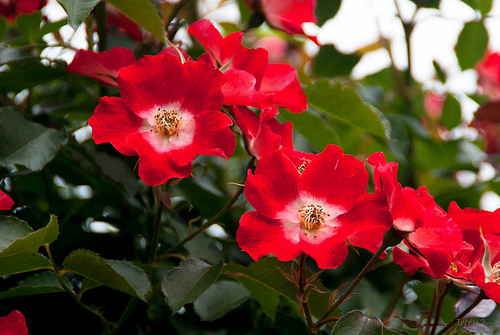

In [25]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

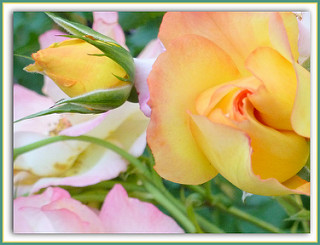

In [26]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# Keras Yardımcı Programını Kullanarak Veri Yükleme

## Bir Veri Seti Olustur

In [27]:
# Bazi parametreleri tamliyoruz!
batch_size = 32
img_height = 180
img_width = 180

In [28]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, # Cicek veri kumesi
    validation_split = 0.2, # %20 dogrulama veri kumesi
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [29]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Yukarıdaki çıktıları açıklamam gerekirse, train_ds çıktısı, 5 sınıfa ait toplam 3670 veri içerdiğini ve bunların 2936'sının eğitim (train) için kullanılacağını belirtiyor. val_ds ise yine 5 sınıfa ait toplam 3670 verinin bulunduğunu ve doğrulama (validation) için 734 verinin kullanılacağını gösteriyor.

In [30]:
# Sinif isimlerine bakalim
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Verileri görselleştirilmesi

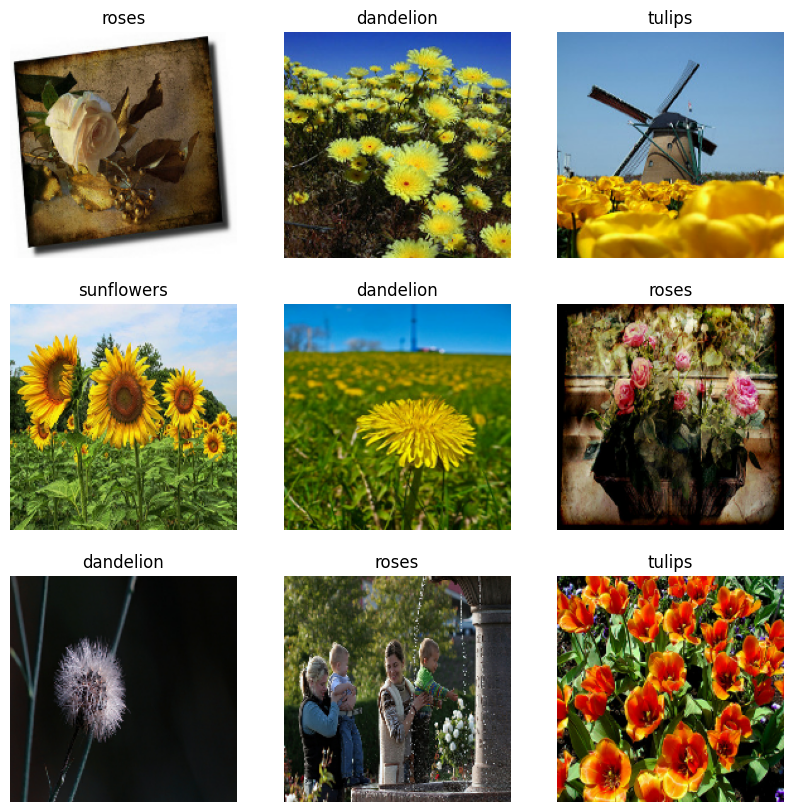

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Yukarıdaki veri kümesini kullanarak bir yapay zeka modelini eğitebilirsiniz. Nasıl eğitim yapacağınız konusunda bir bilginiz yoksa, [buraya tıklayarak](https://github.com/ihsncnkz/TensorflowIC/blob/main/Beginner/ML%20basics%20with%20Keras/Work_On_Tensorflow_2_Beginner_Basic_Classification_Class_images_of_clothing.ipynb) GitHub platformumda paylaştığım diğer çalışmalarıma göz atabilirsiniz.

In [32]:
# Verinin icerigine bakalim
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


(32, 180, 180, 3) = (Veri Miktari, Veri boyutu, Veri boyutu, Renk araligi(RGB))

## Verileri standartlaştırın
Bundan önceki çalışmalarımı incelediyseniz, resim verilerinde '/255' bölme işlemi gerçekleştirdiğimizi görmüşsünüzdür. Bu işlem aslında standartlaştırma işlemidir. RGB resimlerde piksel aralıkları (0-255) arasındadır, bizler ise bu aralığı (0-1) aralığına indirmek için 255'e bölüyoruz.

In [33]:
normalization_layer = tf.keras.layers.Rescaling(1./255) # Bu, bir Rescaling katmanı oluşturur ve giriş verilerini 0 ile 1 arasına normalize eder.

In [34]:
normalize_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalize_ds))
first_image = image_batch[0]
print(np.min(first_image) , np.max(first_image)) # (en dusuk deger, en yuksek deger)

0.0 0.96902645


## Veri setini performansa göre yapılandırın
G/Ç'nin engelleyici hale gelmeden diskten veri alabilmeniz için arabellekli ön yüklemeyi kullandığınızdan emin olalım. Veri yüklerken kullanmanız gereken iki önemli yöntem şunlardır:
- Dataset.cache, görüntülerin ilk epoch sırasında diskten yüklenmesinden sonra bellekte kalmasını sağlar. Bu, modelinizi eğitirken veri kümesinin bir darboğaz haline gelmemesini sağlayacaktır. Veri kümeniz belleğe sığmayacak kadar büyükse, bu yöntemi performanslı bir disk önbelleği oluşturmak için de kullanabilirsiniz.
- Dataset.prefetch Keras ve TensorFlow'da, veri işleme sırasında giriş verilerini önceden yüklemek için kullanılan bir optimizasyon tekniğidir. Bu, eğitim sırasında CPU ve GPU'nun aynı anda çalışmasına olanak tanır ve veri yükleme ile model eğitimi arasındaki bekleme süresini azaltır.

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

- train_ds.cache(): Eğitim verisinin belleğe (RAM) yüklenmesini sağlar. Bu, her epoch'ta veri yeniden diskten okunmak yerine belleğe alınarak eğitim süresini hızlandırır. Eğer veri belleğe sığabiliyorsa, her epoch için veri okuma işlemi yapılmaz.

- train_ds.prefetch(buffer_size = AUTOTUNE): Eğitim verilerinin önceden yüklenmesi için kullanılır. AUTOTUNE, TensorFlow'un en uygun buffer_size değerini otomatik olarak seçmesini sağlar. Bu, verilerin arka planda yüklenmesini sağlayarak eğitim sırasında beklemeyi azaltır.

- val_ds.cache() ve val_ds.prefetch(): Aynı işlemler doğrulama verisi için de uygulanır.

# Model Egitimi
Bu bölümde bir model oluşturup eğitim gerçekleştireceğiz. Bu bölümle birlikte hazırlanmış veri kümesinin eğitimini nasıl yapacağımızı da öğreneceğiz.

In [36]:
num_classes = len(class_names) # 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # Bu katman, giriş görüntülerini 0-255 aralığından 0-1 aralığına normalize eder.
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(num_classes)
])

- tf.keras.layers.Rescaling(1./255): Bu katman, giriş görüntülerini 0-255 aralığından 0-1 aralığına normalize eder. Bu, modelin daha hızlı ve verimli öğrenmesine yardımcı olur.

- tf.keras.layers.Conv2D(32, 3, activation = 'relu'): Bu, bir 2D konvolüsyon katmanıdır. 32 adet 3x3 boyutunda filtre (kernels) kullanarak görüntülerdeki desenleri öğrenir. ReLU aktivasyon fonksiyonu, negatif değerleri sıfırlayıp pozitifleri olduğu gibi bırakır.

- tf.keras.layers.MaxPooling2D(): Max pooling katmanı, her bir 2x2 bölgedeki maksimum değeri alarak özellik haritasını küçültür ve modelin daha az hesaplama yapmasını sağlar.

- tf.keras.layers.Flatten(): Bu katman, 2D özellik haritasını (görüntü) tek bir uzun vektöre dönüştürür. Bu adım, yoğun bağlantılı (fully connected) katmanlarla işlem yapmak için gereklidir.

- tf.keras.layers.Dense(128, activation = 'relu'): Bu, bir yoğun (fully connected) katmandır. 128 nöron kullanarak görüntüden çıkarılan özellikleri işler. ReLU aktivasyon fonksiyonu yine burada kullanılır.

- tf.keras.layers.Dense(num_classes): Son olarak, modelin çıkış katmanıdır. num_classes (sınıf sayısı kadar nöron içerir) ile model, her sınıf için olasılık değerleri üretir. Aktivasyon fonksiyonu belirtilmediği için, bu katman logits çıkışı üretir.

In [37]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

- optimizer='adam': Modelin ağırlıklarını güncellemek için kullanılan Adam optimizasyon algoritması seçilmiştir. Adam, genellikle hızlı ve verimli bir optimizasyon yöntemidir, çünkü her parametre için öğrenme hızını otomatik olarak ayarlayarak daha iyi sonuçlar elde edilmesine yardımcı olur.

- loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True): Modelin tahminleri ile gerçek etiketler arasındaki kaybı ölçmek için kullanılan kayıp fonksiyonu:

- SparseCategoricalCrossentropy: Çok sınıflı sınıflandırma problemlerinde kullanılan bir kayıp fonksiyonudur. Etiketler tamsayı şeklinde verilmişse (her bir sınıf için bir tam sayı etiket), bu fonksiyon kullanılır.
  - from_logits=True: Bu parametre, modelin çıkışlarının logits (yani, son aktivasyon fonksiyonu uygulanmamış ham değerler) olduğunu belirtir. Bu durumda, softmax fonksiyonu kayıp hesaplaması sırasında otomatik olarak uygulanır.
- metrics=['accuracy']: Modelin başarımını değerlendirmek için kullanılan metrik. Bu örnekte, doğruluk (accuracy) metriği kullanılmıştır. Eğitim sırasında doğruluk değerleri hesaplanır ve modelin ne kadar doğru tahminlerde bulunduğunu gösterir.

In [38]:
model.fit(
  train_ds, # Egitim veri seti
  validation_data=val_ds, # Dogrulama veri seti
  epochs=3 # Egitim adim sayisi
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4063 - loss: 1.3645 - val_accuracy: 0.5804 - val_loss: 1.0437
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6145 - loss: 0.9822 - val_accuracy: 0.6240 - val_loss: 0.9864
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6932 - loss: 0.8260 - val_accuracy: 0.6308 - val_loss: 0.9336


# Daha hassas kontrol için tf.data kullanımı
tf.data TensorFlow'un veri yükleme ve işleme için sunduğu bir API'dir. Veri setlerini verimli bir şekilde işlemek, düzenlemek ve model eğitimi sırasında kullanılabilir hale getirmek için kullanılır.<br>
Önceden indirdiğimiz çiçek veri kümesi ile birlikte tf.data kullanarak nasıl çalıştığı konusunda bilgiler edineceğiz.

In [73]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

- list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
  - tf.data.Dataset.list_files(): Bu fonksiyon, belirli bir dizindeki dosyaların listesini almak için kullanılır.
data_dir/'*/*': Bu, data_dir dizinindeki alt dizinlerdeki tüm dosyaları seçmek için kullanılan bir yol desenidir. Bu, tüm alt klasörleri (ve alt klasörlerdeki dosyaları) seçer. * her şeyi ifade eder.
  - shuffle=False: Dosyaların sıralaması karıştırılmaz, yani liste sırasına göre gelir.
Bu satırda, data_dir içinde yer alan tüm dosya yolları bir tf.data.Dataset nesnesine dönüştürülür.

- list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)
  - shuffle(image_count): Burada, image_count değişkeni veri setindeki toplam dosya sayısını temsil eder ve dosyaların sırasını karıştırır. Bu, eğitim sırasında modelin veriye daha iyi genelleme yapabilmesini sağlar.
  - reshuffle_each_iteration=False: Bu parametre, her eğitim iterasyonunda verilerin tekrar karıştırılmamasını sağlar. Yani, bir kez karıştırıldıktan sonra sıralama sabit kalır. Eğer bu parametre True olsaydı, her epoch'ta (eğitim dönemi) dosyaların sıralaması yeniden karıştırılırdı.

In [74]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/4407065098_ef25f1ccac_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/1484598527_579a272f53.jpg'
b'/root/.keras/datasets/flower_photos/daisy/11642632_1e7627a2cc.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/1667963621_c76d570af3_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/2197754124_5c8a146761_n.jpg'


In [75]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [76]:
# Veri setinin egitim ve dogrulama olarak ayirlmasi
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [77]:
print(tf.data.experimental.cardinality(train_ds).numpy()) #  Egitim veri setindeki veri miktari
print(tf.data.experimental.cardinality(val_ds).numpy()) #  test veri setindeki veri miktari

2936
734


In [78]:
"""Bu fonksiyon, bir dosya yolunu alır ve yolun içinde bulunan sınıf adını (ilk dizini) kullanarak, dosyanın ait olduğu sınıfın indeksini döndürür.
Bu indeks, daha sonra modelin eğitiminde kullanılacak olan etiket (label) olarak kullanılır."""
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

In [79]:
"""decode_img(img) fonksiyonu, img adlı bayt formatındaki bir JPEG resmini alır, onu RGB formatında çözümleyip (3 kanal) tensor'a dönüştürür ve ardından belirtilen boyutlara yeniden boyutlandırır."""
def decode_img(img):
  img = tf.io.decode_jpeg(img, channels = 3)
  return tf.image.resize(img, [img_height, img_width])

In [80]:
# Yukaridaki yazdigimiz fonksoyonlarin birlestiren fonksiyon
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [81]:
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [82]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


## Performans için veri setini yapılandırılması
Bu veri kümesiyle bir model eğitmek için şu verilere ihtiyacınız olacak:
- Veri setinin genelleme yeteneğini artırmak için, içerisindeki verilerin iyi bir şekilde karıştırılması gerekmektedir.
- Doğru bir şekilde paketlenmesi (batch) gerekir.
- Paketleri (Batches) hızlı bir şekilde alması gerekir.<br>

Bu işlemlerin hepsini tf.data kullanarak gerçekleştireceğiz.

In [84]:
def configure_for_performance(ds):
  ds = ds.cache() # Dataset verilerinin belleğe yüklenmesini sağlar. Bu işlem, verilerin tekrar tekrar okuma yerine hafızada tutulmasını sağlar, böylece veri yükleme süresi hızlanır.
  ds = ds.shuffle(buffer_size = 1000) # Dataset'in sırasını karıştırır. Bu, modelin daha genelleştirilebilir hale gelmesine yardımcı olur çünkü her eğitim döngüsünde farklı veri sırasıyla çalışılır.
  ds = ds.batch(batch_size) # Dataset'i belirtilen batch_size (toplu veri boyutu) kadar küçük parçalara böler. Bu, modelin daha verimli çalışabilmesi ve bellek kullanımının optimize edilmesi için gereklidir.
  ds = ds.prefetch(buffer_size = AUTOTUNE) # Eğitim sırasında veri yüklemeyi asenkron hale getirir. Bu, model eğitimine başlamak için veri önceden yüklenmeye başlar ve modelin eğitim süresi boyunca veri yüklenmesi beklenmez.
  return ds

In [85]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Verileri görselleştirin

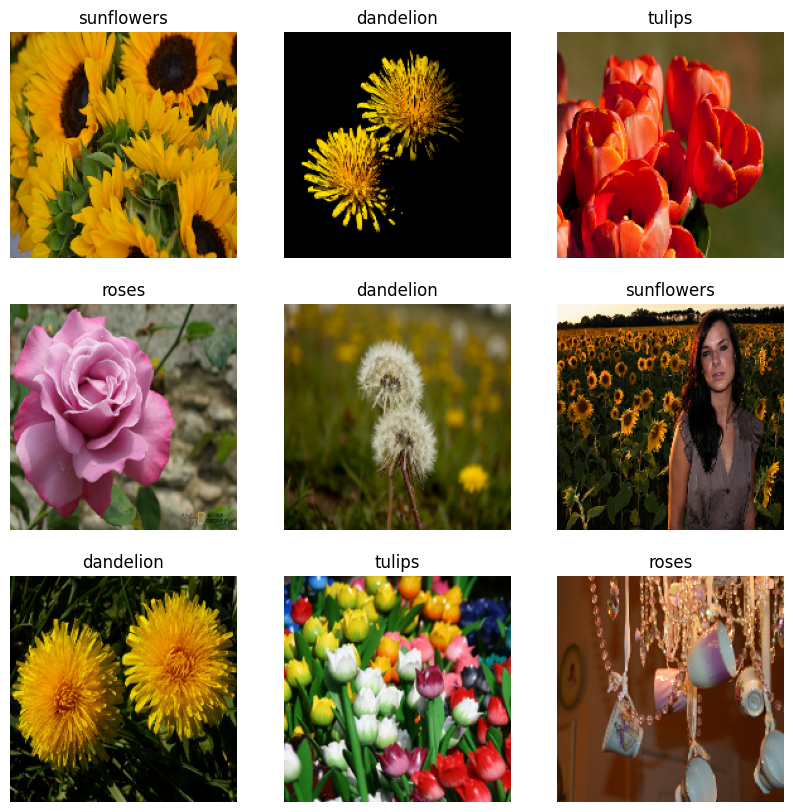

In [86]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Modelin Eğitilmesi

In [87]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7333 - loss: 0.7241 - val_accuracy: 0.7330 - val_loss: 0.7117
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8066 - loss: 0.5218 - val_accuracy: 0.7425 - val_loss: 0.7441
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8831 - loss: 0.3277 - val_accuracy: 0.7643 - val_loss: 0.7367


# Using TensorFlow Datasets

In [88]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # verinin ismi
    split= ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # egitim veri kumesi, dogrulama ve test veri kumesinun boyutlari
    with_info = True, # Bu parametre, veri kümesinin yanında metadata (ekstra bilgiler) döndürülmesini sağlar.
    as_supervised = True # Bu parametre, veri kümesinin etiketlerle birlikte ((input, label) şeklinde) döndürülmesini sağlar.
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [89]:
# sinif sayisi
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


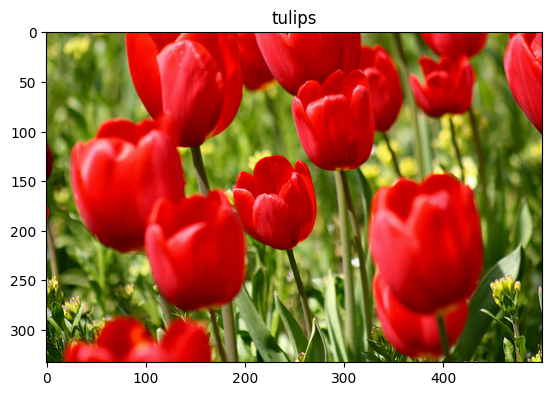

In [90]:
# Veri seti icerisinde veri gorsellestirme
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [92]:
# Verilerin egitim icin uygun hale getirilmesi
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

# Sonuc
TensorFlow üzerindeki bu çalışma serüvenimizin Image bölümü sonuna geldi. Bu çalışmamızda üç farklı veri indirme işlemi gördük ve veri seti hazırlama aşamaları ile birlikte küçük bir eğitim gerçekleştirdik. Umarım bu çalışma hoşunuza gitmiş ve sizin için faydalı olmuştur. İyi günler, iyi çalışmalar dilerim.

Aşağıdaki Linklerden beni takip edebilir ve yapacağım çalışmalardan haberdar olabilirsiniz!<br>
[Linkedin](https://www.linkedin.com/in/ihsancenkiz/)<br>
[Github](https://github.com/ihsncnkz)<br>
[Kaggle](https://www.kaggle.com/ihsncnkz)